There are 20 trials: X1, X2, ..., X20
keep the depth as 10

Each trial has sequence of points: X1 = {x11, x12, x13, ..., x15}

Algorithm:
    1. upload X1 with given depth for 9 different objects
    2. optimize hyperparameters for all of the models
    3. predict depth+1, record probability, get label
    4. re-upload X1 with new, remove anything far before depth+1

In [17]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.optimize import fmin_l_bfgs_b
from sklearn.datasets.samples_generator import make_blobs
from scipy.linalg import cholesky, cho_solve, solve_triangular
from scipy.spatial.distance import pdist, squareform

In [37]:
sigma_n_square = 1e-10

### Create fake dataset

In [18]:
# create fake dataset
X_data, y_data = make_blobs(n_samples=10, centers=2, n_features=2, random_state=10) # 26
y_data[y_data==0] = -1

y_data = y_data.reshape(-1,1)

In [19]:
# number of dimension
D = X_data.shape[1]

In [20]:
X = X_data[:25,:]
y = y_data[:25]

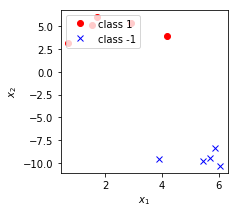

In [21]:
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(X[y.flatten()==1][:, 0], X[y.flatten()==1][:,1], 'ro', label='class 1')
ax.plot(X[y.flatten()==-1][:, 0], X[y.flatten()==-1][:,1], 'bx', label = 'class -1')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#ax.set_xlim(-10, 10)
#ax.set_ylim(-5, 15)
ax.legend(loc='upper left')
plt.show()

In [23]:
# depth  = 3
# for it in range(X_data.shape)

#### Kernels

We squared exponential kerne (a.k.a RBF) with hyperparameter $l$:
$$ K(x_i, x_j) = \exp \Big(\frac{-|| x_i - x_j ||^2}{2l^2} \Big) $$

In [104]:
def squared_exp_kernel(X, theta_):
    pairwise_dists = squareform(pdist(X, 'euclidean'))**2
    K = np.exp(-pairwise_dists/ (2 * theta_[0] ** 2))
    K_gradient = np.multiply(pairwise_dists/(theta_[0]**3), K)
    return K, np.expand_dims(K_gradient, axis=2)

def squared_exp_kernel_func(a, b, theta_):
    # theta includes number of parameters
    squared_dist = np.linalg.norm(a-b)**2
    k = np.exp(-squared_dist/(2*theta_[0]**2))
    return k

In [151]:
def ard_squared_exp_kernel(X, theta_):
    #%%timeit -n 1000
    pairwise_dists = squareform(pdist(X, 'minkowski', p=2, w=(1/theta_**2)))**2
    K = np.exp(-pairwise_dists/2)
    
    # calculate gradient
    temp_X = np.zeros([X.shape[0], 2])
    K_gradients = []
    for dim in range(X.shape[1]):
        temp_X[:,dim] = X[:,dim].copy()
        temp_K = squareform( pdist(temp_X, 'sqeuclidean')/theta_[dim]**3 )
        K_gradients.append(np.expand_dims(np.multiply(K, temp_K), axis=2))
    return K, np.array(K_gradients)

def ard_exp_kernel(a, b, theta_):
    # theta includes number of parameters
    squared_dist = (a-b)**2
    squared_dist = np.dot(squared_dist, 1/theta_**2)
    return np.exp(-squared_dist/2)

In [152]:
K, K_gradient = ard_squared_exp_kernel(X, x0)

In [153]:
K_gradient[0].shape

(10, 10, 1)

#### Optimization

We need find paramaters of kernel, in our case it's $l$ to maximize log marginal likelihood.

$$ \mathcal{L} = \log p(\mathbf{y}|X) = -\frac{1}{2} \mathbf{y}^T \mathbf{\alpha} - \sum_{i}^{N}L_{ii} - \frac{N}{2} \log(2 \pi) $$

In [136]:
x0 = np.array([1, 1])
bounds =  ( (1e-2, 1e2), (1e-2, 1e2), )

In [154]:
def log_marginal_likelihood(theta_, *args):
    #print(kernel_func)
    
    #K, K_gradient = squared_exp_kernel(X, theta_=theta_)
    K, K_gradient = ard_squared_exp_kernel(X, theta_=theta_)


    # do Cholesky decomposition
    L = cholesky(K + sigma_n_square*np.eye(len(X)), lower=True)
    #print(L)
    # solve for alpha
    alpha = cho_solve(  (L, True), y )
    #print(K_gradient.shape)
    
    tmp = np.einsum("ik,jk->ijk", alpha, alpha)  # k: output-dimension
    tmp -= cho_solve((L, True), np.eye(K.shape[0]))[:, :, np.newaxis]
    
    log_likelihood_gradients = []
    for dim in range(X.shape[1]):
        log_likelihood_gradient_dims = 0.5 * np.einsum("ijl,ijk->kl", tmp, K_gradient[dim])
        log_likelihood_gradient = log_likelihood_gradient_dims.sum(-1)
        log_likelihood_gradients.append(-log_likelihood_gradient)
    
    return -( -0.5*np.dot(y.T, alpha) - np.sum(np.log(L.diagonal())) - X.shape[0]/2*np.log(2*np.pi) ), np.array(log_likelihood_gradients)

In [155]:
def optimize_kernel_parameters(x0):
    #x0 = np.array([1])
    
    #bounds =  ((1e-2, 1e2),(1e-2, 1e2),)
    theta_estimate, min_log_marginal_likelihood, info = fmin_l_bfgs_b(func=log_marginal_likelihood, x0 = x0, args=(), bounds=bounds)
    print('Optimization succeded with log marginal likelihood ', min_log_marginal_likelihood[0][0], ' in ', info['funcalls'],' iterations.')
    return  theta_estimate, min_log_marginal_likelihood, info

In [156]:
OPTIMIZATION_ITERATIONS = 10

In [158]:
theta_estimate, min_log_marginal_likelihood, info = optimize_kernel_parameters(x0)

Optimization succeded with log marginal likelihood  -11.446608590876075  in  53  iterations.


In [159]:
theta_estimate

array([23.39804701,  6.26470966])

In [99]:
bounds

array([[1.e-02, 1.e+02]])

In [160]:
%%time
log_likelihood_list = []
theta_est_list  = []
for i in range(OPTIMIZATION_ITERATIONS):
    bounds = np.array(bounds)
    theta_initial = np.random.uniform(bounds[:, 0], bounds[:, 1])
    theta_estimate, min_log_marginal_likelihood, info = optimize_kernel_parameters(x0)
    log_likelihood_list.append(min_log_marginal_likelihood[0][0])
    theta_est_list.append(theta_estimate)

Optimization succeded with log marginal likelihood  -11.446608590876075  in  53  iterations.
Optimization succeded with log marginal likelihood  -11.446608590876075  in  53  iterations.
Optimization succeded with log marginal likelihood  -11.446608590876075  in  53  iterations.
Optimization succeded with log marginal likelihood  -11.446608590876075  in  53  iterations.
Optimization succeded with log marginal likelihood  -11.446608590876075  in  53  iterations.
Optimization succeded with log marginal likelihood  -11.446608590876075  in  53  iterations.
Optimization succeded with log marginal likelihood  -11.446608590876075  in  53  iterations.
Optimization succeded with log marginal likelihood  -11.446608590876075  in  53  iterations.
Optimization succeded with log marginal likelihood  -11.446608590876075  in  53  iterations.
Optimization succeded with log marginal likelihood  -11.446608590876075  in  53  iterations.
CPU times: user 759 ms, sys: 13.9 ms, total: 773 ms
Wall time: 751 ms


In [101]:
theta_estimate[np.argmin(log_likelihood_list)]

6.065800964396905

In [102]:
info

{'grad': array([6.55392809e-06]),
 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
 'funcalls': 8,
 'nit': 7,
 'warnflag': 0}

In [103]:
theta_estimate

array([6.06580096])

In [108]:
# make prediction
def predict(x_star, theta_):

    # create covariance matrix using kernel
    #K = pairwise_kernels(X, metric=kernel_func,  theta_=theta)
    K, _ = squared_exp_kernel(X, theta_=theta_)

    # do Cholesky decomposition
    L = cholesky(K + sigma_n_square*np.eye(X.shape[0]), lower=True)

    # solve for alpha
    alpha = cho_solve(    (L, True),    y   )
    
    L_inv = solve_triangular(L.T, np.eye(L.shape[0]))
    K_inv = L_inv.dot(L_inv.T)

    k_star = pairwise_kernels(x_star, X, metric=squared_exp_kernel_func,  theta_= theta_)
    y_mean = k_star.dot(alpha) + np.mean(y)
    y_var = np.ones(x_star.shape[0]) - np.einsum("ij,ij->i", np.dot(k_star, K_inv), k_star)
    y_var[y_var < 0] = 0

    # log marginal likelihood
    log_marg_likelihood = -0.5*np.dot(y.T, alpha) - np.sum(np.log(L.diagonal())) - X.shape[0]/2*np.log(2*np.pi)
    
    #print(-0.5*np.dot(y.T, alpha) - np.sum(np.log(L.diagonal())) - X.shape[0]/2*np.log(2*np.pi))
    return y_mean, np.sqrt(y_var), log_marg_likelihood

In [111]:
y_pred, y_sigma, y_log_lh = predict(X_data, theta_estimate)

In [110]:
y_sigma, sigma2

NameError: name 'sigma2' is not defined

In [28]:
y_log_lh

array([[43.6235042]])

In [112]:
y_pred

array([[-0.99999999],
       [ 1.        ],
       [ 1.        ],
       [ 1.00000001],
       [-1.        ],
       [ 1.        ],
       [-1.00000002],
       [-1.        ],
       [-0.99999999],
       [ 1.        ]])

In [113]:
y_sigma

array([9.81604309e-06, 1.00032584e-05, 9.99789077e-06, 1.00063544e-05,
       9.89447202e-06, 9.99609722e-06, 9.93188943e-06, 9.86513143e-06,
       9.96443223e-06, 9.99888458e-06])

In [31]:
y_data[26:28]

array([[1],
       [1]])

In [32]:
1/np.sqrt(2*np.pi*y_sigma[0]**2)*np.exp( - (y_pred[0] - 1)**2 / (2*y_sigma[0]**2) )

array([1.16527088e-07])

Gaussian distribution
$$ p(x | \mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2} } \exp \Big( - \frac{(x-\mu)^2}{2\sigma^2} \Big) $$

In [33]:
y_data[26:40].faltten()

AttributeError: 'numpy.ndarray' object has no attribute 'faltten'

In [118]:
def gaussian_pdf(x_, mu_, sigma_):
    return  np.exp( - (x_ - mu_)**2 / (2 * sigma_**2) )* 1/ ( np.sqrt(2*np.pi) * sigma_)

In [119]:
y_pred

array([[-0.99999999],
       [ 1.        ],
       [ 1.        ],
       [ 1.00000001],
       [-1.        ],
       [ 1.        ],
       [-1.00000002],
       [-1.        ],
       [-0.99999999],
       [ 1.        ]])

In [120]:
gaussian_pdf(y_pred.flatten(), y_data.flatten(), y_sigma)

array([40641.85639195, 39881.23215949, 39902.64396791, 39868.88837463,
       40319.71353363, 39909.79930151, 40167.75604571, 40439.62815955,
       40036.62161825, 39898.67799849])

In [121]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [122]:
# Instantiate a Gaussian Process model
kernel = RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=sigma_n_square)

In [123]:
%%time
# train GP model
gp.fit(X, y.flatten())

CPU times: user 45.7 ms, sys: 4.09 ms, total: 49.8 ms
Wall time: 45.4 ms


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [124]:
1/1.78*2

1.1235955056179776

In [125]:
gp.kernel_.theta

array([1.80266611])

In [126]:
gp.log_marginal_likelihood_value_

5.875832117180522

In [127]:
y_pred2, sigma2 = gp.predict(X=X_data, return_std=True)

In [128]:
y_pred2

array([-0.99999999,  1.        ,  1.        ,  1.00000001, -1.        ,
        1.        , -1.00000002, -1.        , -0.99999999,  1.        ])

In [129]:
sigma2

array([9.93620892e-06, 1.00108858e-05, 1.00121167e-05, 1.00114957e-05,
       9.75286977e-06, 1.00172440e-05, 9.81737762e-06, 9.76996994e-06,
       9.73029852e-06, 1.00103368e-05])

In [130]:
gaussian_pdf(x_ = y_pred2[2], mu_= -1, sigma_=sigma2[2] )

0.0

In [131]:
gaussian_pdf(x_= y_pred2 , mu_= y_data.flatten(), sigma_=sigma2)

array([40150.34489746, 39850.84627075, 39845.94740138, 39848.41414472,
       40905.11684126, 39825.54836939, 40636.27923523, 40833.51824499,
       40999.99584721, 39853.03233327])

In [93]:
gp.kernel_

RBF(length_scale=6.07)

In [132]:
y_pred2, y_pred

(array([-0.99999999,  1.        ,  1.        ,  1.00000001, -1.        ,
         1.        , -1.00000002, -1.        , -0.99999999,  1.        ]),
 array([[-0.99999999],
        [ 1.        ],
        [ 1.        ],
        [ 1.00000001],
        [-1.        ],
        [ 1.        ],
        [-1.00000002],
        [-1.        ],
        [-0.99999999],
        [ 1.        ]]))

In [119]:
sigma2, y_sigma

(array([0.00000000e+00, 2.97069159e-05]), array([0., 0.]))